In [ ]:
#pip install praw pydantic ollama

  Using cached websocket_client-1.8.0-py3-none-any.whl.metadata (8.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 293.1 kB/s eta 0:00:00a 0:00:01
Using cached websocket_client-1.8.0-py3-none-any.whl (58 kB)
Note: you may need to restart the kernel to use updated packages.


In [28]:
import praw

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from pydantic import BaseModel, Field, ValidationError
from typing import Literal

import ollama

In [4]:
import logging
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
for logger_name in ("praw", "prawcore"):
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.DEBUG)
    logger.addHandler(handler)

In [11]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [12]:
client_id = os.getenv("REDDIT_CLIENT_ID")
client_secret = os.getenv("REDDIT_CLIENT_SECRET")


In [13]:
reddit = praw.Reddit(
client_id =client_id,
client_secret = client_secret,
user_agent='Windows:reddit_bitcoin_scraper:v1 (by /u/Critical_Product_103)',
)

In [14]:
subreddits_of_interest = ["WallStreetElite", "btc"]

In [16]:
subreddits = reddit.subreddit("+".join(subreddits_of_interest))

In [17]:
start_date = '2024-01-01'
start_date = pd.to_datetime(start_date).tz_localize('UTC')

In [18]:
posts_by_date = defaultdict(list)

for post in subreddits.top(time_filter= "year", limit=None):
    post_date = pd.to_datetime(post.created_utc, unit='s', utc=True)

    if post_date > start_date:
        # Collect the details of the post without comments
        post_data = {
            "post_id": post.id,  # Post ID
            "title": post.title,
            "body": post.selftext if post.selftext else "No text body (link post)",
            "author": post.author.name if post.author else "Unknown",  # Post author
            "upvotes": post.ups,  # Number of upvotes
            "downvotes": post.downs,  # Number of downvotes
            "score": post.score,  # Post score (upvotes - downvotes)
            "num_comments": post.num_comments,  # Number of comments
            "url": post.url,  # URL of the post
            "created_at": post_date,  # Post creation date
            "subreddit": post.subreddit.display_name,  # Subreddit name
        }

        # Append to the respective date key
        posts_by_date[post_date].append(post_data)
    
    else:
        continue

Fetching: GET https://oauth.reddit.com/r/WallStreetElite+btc/top at 1742181482.694273
Data: None
Params: {'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (75394 bytes) (rst-116:rem-999.0:used-1 ratelimit) at 1742181485.290025
Fetching: GET https://oauth.reddit.com/r/WallStreetElite+btc/top at 1742181485.320608
Data: None
Params: {'after': 't3_1bxzcyo', 'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (85723 bytes) (rst-113:rem-998.0:used-2 ratelimit) at 1742181487.4902132
Fetching: GET https://oauth.reddit.com/r/WallStreetElite+btc/top at 1742181487.515249
Data: None
Params: {'after': 't3_1fq2hab', 'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (80348 bytes) (rst-111:rem-997.0:used-3 ratelimit) at 1742181489.7902741
Fetching: GET https://oauth.reddit.com/r/WallStreetElite+btc/top at 1742181489.806517
Data: None
Params: {'after': 't3_1hu6i50', 'limit': 1024, 'raw_json': 1, 't': 'year'}
Response: 200 (70073 bytes) (rst-109:rem-996.0:used-4 ratelimit) at 1742181

In [19]:
df = pd.DataFrame([p for posts in posts_by_date.values() for p in posts])


In [20]:
df

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit
0,1i6xl1t,Trump announces full and unconditional pardon ...,No text body (link post),zrad603,1412,0,1412,548,https://i.redd.it/hzedeg31tfee1.png,2025-01-22 00:10:08+00:00,btc
1,1i73uzd,Ross Ulbricht is FREE!,No text body (link post),zrad603,640,0,640,235,https://i.redd.it/hqg98kb9chee1.jpeg,2025-01-22 05:18:44+00:00,btc
2,1gbmdym,The greatest sh*t coin ever created,No text body (link post),FluffyAd3310,200,0,200,60,https://i.redd.it/iaqlfjel1uwd1.jpeg,2024-10-25 04:47:30+00:00,btc
3,1i8k3g9,Trump signing the new Crypto Executive Order,No text body (link post),QING-CHARLES,190,0,190,79,https://v.redd.it/k7potcz8iuee1,2025-01-24 01:39:53+00:00,btc
4,1ggb314,"On this day 16 years ago, Satoshi Nakamoto pub...",No text body (link post),rey4486,181,0,181,54,https://i.redd.it/nswf6smbh2yd1.jpeg,2024-10-31 10:16:02+00:00,btc
...,...,...,...,...,...,...,...,...,...,...,...
827,1hhpghn,El Salvador makes Bitcoin payments voluntary i...,No text body (link post),Dune7,21,0,21,12,https://cointelegraph.com/news/el-salvador-bit...,2024-12-19 09:46:28+00:00,btc
828,1hbssum,The industry’s deliberate misdefinition of dec...,"u/michaelAischmann said "" I agree that BTC is ...",Sprint1999,20,0,20,4,https://www.reddit.com/r/btc/comments/1hbssum/...,2024-12-11 12:53:59+00:00,btc
829,1haa1x2,Blocksize Limits and Capacity Planning (GP Sho...,No text body (link post),GeneralProtocols,21,0,21,0,https://v.redd.it/3bw8vqjjut5e1,2024-12-09 13:46:17+00:00,btc
830,1h4pygp,"Maxis Call It 'bcash,' But We Call It the Futu...",I was browsing X and I was surprised to see th...,alberdioni8406_,20,0,20,9,https://read.cash/@alberdioni8406/maxis-call-i...,2024-12-02 07:52:29+00:00,btc


In [21]:
df['date_created'] = df['created_at'].dt.date
df_sorted = df.sort_values(by=['date_created','created_at']).reset_index(drop=True)

In [22]:
df_sorted.value_counts('date_created')

date_created
2024-03-22    24
2024-05-02     9
2024-04-10     9
2024-04-07     9
2024-03-20     8
              ..
2024-09-19     1
2024-09-18     1
2024-09-13     1
2024-09-12     1
2025-01-25     1
Name: count, Length: 277, dtype: int64

In [23]:
df_sorted

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created
0,1bgvem2,What is this subs position on the idea that BC...,I've just found out that this sub is not just ...,fverdeja,22,0,22,101,https://www.reddit.com/r/btc/comments/1bgvem2/...,2024-03-17 11:33:01+00:00,btc,2024-03-17
1,1bgzhfq,My new book on the hijacking of Bitcoin is alr...,No text body (link post),MemoryDealers,153,0,153,60,https://i.redd.it/8o0gmv3irwoc1.png,2024-03-17 14:56:00+00:00,btc,2024-03-17
2,1bh2joz,/r/CryptoCurrency is just as censored as /r/Bi...,No text body (link post),MemoryDealers,114,0,114,164,https://i.redd.it/5h1ovgb8exoc1.png,2024-03-17 17:01:46+00:00,btc,2024-03-17
3,1bh5og5,https://bchtoronto.com Flipstarter fully funde...,"With just 6 days left, our meetup flipstarter ...",Coins4Clothes,23,0,23,0,https://www.reddit.com/r/btc/comments/1bh5og5/...,2024-03-17 19:08:25+00:00,btc,2024-03-17
4,1bhh9n6,"Hijacking Bitcoin - whether you agree or not, ...",No text body (link post),Alex-Crypto,65,0,65,18,https://i.redd.it/gi5j76hwi0pc1.jpeg,2024-03-18 03:34:08+00:00,btc,2024-03-18
...,...,...,...,...,...,...,...,...,...,...,...,...
827,1i8fcmy,Donald Trump Signs Executive Order to Evaluate...,President Donald Trump signed an executive ord...,coinfanking,43,0,43,26,https://news.bitcoin.com/donald-trump-signs-ex...,2025-01-23 22:01:27+00:00,btc,2025-01-23
828,1i8k3g9,Trump signing the new Crypto Executive Order,No text body (link post),QING-CHARLES,190,0,190,79,https://v.redd.it/k7potcz8iuee1,2025-01-24 01:39:53+00:00,btc,2025-01-24
829,1i95ey2,"Trump creates crypto group, but no bitcoin sto...",No text body (link post),lalaci,22,0,22,37,https://www.axios.com/2025/01/23/trump-bitcoin...,2025-01-24 20:40:48+00:00,btc,2025-01-24
830,1i97edd,Blown away by the number and variety of busine...,No text body (link post),susonotabi,78,0,78,42,https://x.com/BCHArgentina/status/188283505500...,2025-01-24 22:06:28+00:00,btc,2025-01-24


In [ ]:
model_name = "llama3.2"

def classify_post(title, body):
    prompt = f"Determine if this Reddit post is relevant to Bitcoin news:\nTitle: {title}\nBody: {body}\nAnswer 'Yes' or 'No' only."
    response = ollama.chat(model=model_name, messages=[{"role": "user", "content": prompt}])
    print(response)
    return response["message"]["content"]

In [30]:
df_sorted['is_relevant'] = df_sorted.apply(lambda x: classify_post(x['title'], x['body']), axis=1)

In [31]:
df_sorted

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created,is_relevant
0,1bgvem2,What is this subs position on the idea that BC...,I've just found out that this sub is not just ...,fverdeja,22,0,22,101,https://www.reddit.com/r/btc/comments/1bgvem2/...,2024-03-17 11:33:01+00:00,btc,2024-03-17,This Reddit post is indeed relevant to Bitcoin...
1,1bgzhfq,My new book on the hijacking of Bitcoin is alr...,No text body (link post),MemoryDealers,153,0,153,60,https://i.redd.it/8o0gmv3irwoc1.png,2024-03-17 14:56:00+00:00,btc,2024-03-17,No. The post does not contain any specific new...
2,1bh2joz,/r/CryptoCurrency is just as censored as /r/Bi...,No text body (link post),MemoryDealers,114,0,114,164,https://i.redd.it/5h1ovgb8exoc1.png,2024-03-17 17:01:46+00:00,btc,2024-03-17,Yes. The post links to a subreddit (/r/CryptoC...
3,1bh5og5,https://bchtoronto.com Flipstarter fully funde...,"With just 6 days left, our meetup flipstarter ...",Coins4Clothes,23,0,23,0,https://www.reddit.com/r/btc/comments/1bh5og5/...,2024-03-17 19:08:25+00:00,btc,2024-03-17,"No, this Reddit post is not relevant to Bitcoi..."
4,1bhh9n6,"Hijacking Bitcoin - whether you agree or not, ...",No text body (link post),Alex-Crypto,65,0,65,18,https://i.redd.it/gi5j76hwi0pc1.jpeg,2024-03-18 03:34:08+00:00,btc,2024-03-18,No. The post does not contain any information ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,1i8fcmy,Donald Trump Signs Executive Order to Evaluate...,President Donald Trump signed an executive ord...,coinfanking,43,0,43,26,https://news.bitcoin.com/donald-trump-signs-ex...,2025-01-23 22:01:27+00:00,btc,2025-01-23,Yes. The post is relevant to Bitcoin news as i...
828,1i8k3g9,Trump signing the new Crypto Executive Order,No text body (link post),QING-CHARLES,190,0,190,79,https://v.redd.it/k7potcz8iuee1,2025-01-24 01:39:53+00:00,btc,2025-01-24,Yes.
829,1i95ey2,"Trump creates crypto group, but no bitcoin sto...",No text body (link post),lalaci,22,0,22,37,https://www.axios.com/2025/01/23/trump-bitcoin...,2025-01-24 20:40:48+00:00,btc,2025-01-24,No.
830,1i97edd,Blown away by the number and variety of busine...,No text body (link post),susonotabi,78,0,78,42,https://x.com/BCHArgentina/status/188283505500...,2025-01-24 22:06:28+00:00,btc,2025-01-24,Yes. The post mentions a specific country (Arg...


In [36]:
#df_filtered = df_sorted[df_sorted['is_relevant'].str.contains('Yes')]
#df_filtered = df_filtered.sort_values(by = 'created_at', ascending = True)
#want to select lower case yes or "indeed"
df_filtered = df_sorted[df_sorted['is_relevant'].str.contains('yes|indeed', case=False, regex=True)]
df_filtered = df_filtered.sort_values(by = 'created_at', ascending = True)

In [37]:
df_filtered

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created,is_relevant
0,1bgvem2,What is this subs position on the idea that BC...,I've just found out that this sub is not just ...,fverdeja,22,0,22,101,https://www.reddit.com/r/btc/comments/1bgvem2/...,2024-03-17 11:33:01+00:00,btc,2024-03-17,This Reddit post is indeed relevant to Bitcoin...
2,1bh2joz,/r/CryptoCurrency is just as censored as /r/Bi...,No text body (link post),MemoryDealers,114,0,114,164,https://i.redd.it/5h1ovgb8exoc1.png,2024-03-17 17:01:46+00:00,btc,2024-03-17,Yes. The post links to a subreddit (/r/CryptoC...
6,1bhp7xo,"""Congrats @GeneralProtocol for the AnyHedge TV...",No text body (link post),Mr-Zwets,33,0,33,1,https://x.com/GeukensMathieu/status/1769697476...,2024-03-18 12:12:27+00:00,btc,2024-03-18,"Yes. The post mentions Bitcoin Cash (BCH), whi..."
8,1bhu9ag,r/cc users are realizing that BTC & ETH do not...,No text body (link post),rareinvoices,40,0,40,21,https://np.reddit.com/r/CryptoCurrency/comment...,2024-03-18 16:00:34+00:00,btc,2024-03-18,Yes. The post mentions Bitcoin (BTC) specifica...
13,1bimgtq,"240,000 BCH has gone through AnyHedge smart co...",No text body (link post),GeneralProtocols,31,0,31,13,https://v.redd.it/z9pz0p5c3bpc1,2024-03-19 15:07:20+00:00,btc,2024-03-19,Yes.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,1i8dtac,What happened on r-bitcoin?,"Hello, I came across this sub after many month...",Training-Fig4889,21,0,21,113,https://www.reddit.com/r/btc/comments/1i8dtac/...,2025-01-23 20:57:16+00:00,btc,2025-01-23,Yes. The post mentions specific events (the bl...
827,1i8fcmy,Donald Trump Signs Executive Order to Evaluate...,President Donald Trump signed an executive ord...,coinfanking,43,0,43,26,https://news.bitcoin.com/donald-trump-signs-ex...,2025-01-23 22:01:27+00:00,btc,2025-01-23,Yes. The post is relevant to Bitcoin news as i...
828,1i8k3g9,Trump signing the new Crypto Executive Order,No text body (link post),QING-CHARLES,190,0,190,79,https://v.redd.it/k7potcz8iuee1,2025-01-24 01:39:53+00:00,btc,2025-01-24,Yes.
830,1i97edd,Blown away by the number and variety of busine...,No text body (link post),susonotabi,78,0,78,42,https://x.com/BCHArgentina/status/188283505500...,2025-01-24 22:06:28+00:00,btc,2025-01-24,Yes. The post mentions a specific country (Arg...


In [38]:
len(df_filtered)

399

In [39]:
df_filtered['date_created'] = pd.to_datetime(df_filtered['date_created'])

iso_calendar = df_filtered['date_created'].dt.isocalendar()
df_filtered['year'] = iso_calendar.year  # Use ISO year instead of dt.year
df_filtered['week'] = iso_calendar.week
df_filtered['day'] = df_filtered['date_created'].dt.dayofweek

heatmap_data = df_filtered.groupby(['year', 'week', 'day']).size().unstack()

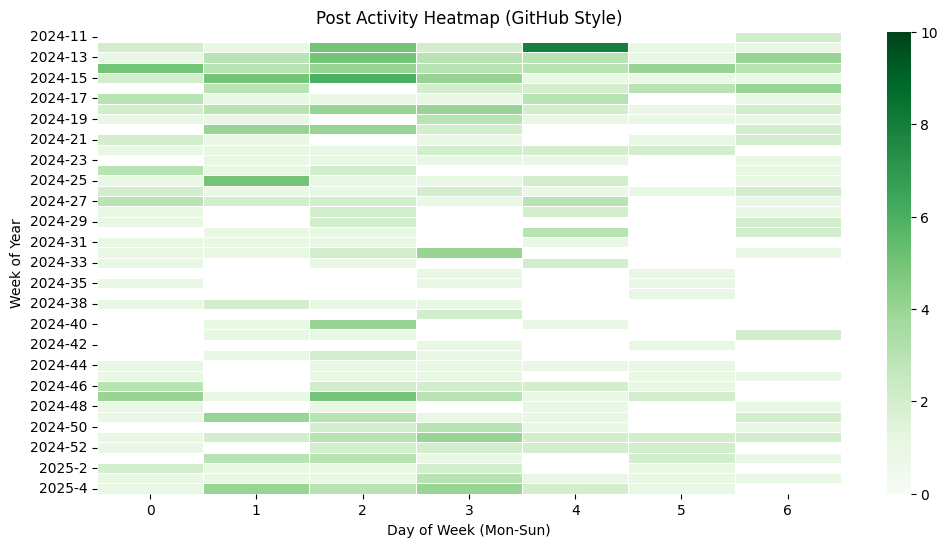

In [40]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="Greens", linewidths=0.5, linecolor="white", vmin=0, vmax=10)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Post Activity Heatmap (GitHub Style)")

plt.show()

In [41]:
def get_top_comments(post_id, limit=100):
    """
    Function to fetch the top comments for a given Reddit post by post_id.
    """
    try:
        # Fetch the submission (post) using its ID
        submission = reddit.submission(id=post_id)
        
        # Get top comments (replace 'limit' with 200 to get the top 200 comments)
        submission.comments.replace_more(limit=0)  # Avoid "MoreComments" object
        top_comments = submission.comments.list()
        
        # Limit to the top 100 comments
        top_comments = top_comments[:limit]
        
        return [comment.body for comment in top_comments]  # Return the comment bodies
    
    except Exception as e:
        print(f"Error fetching comments for post {post_id}: {e}")
        return []

# Example to add top comments to your DataFrame
def run_func(df):
    top_comments_list = []
    for post_id in df['post_id']:
        if post_id:
            comments = get_top_comments(post_id)
        else:
            comments = []
        top_comments_list.append(comments)
    return top_comments_list

In [42]:
top_comments_list = run_func(df_filtered)

Fetching: GET https://oauth.reddit.com/comments/1bgvem2/ at 1742185468.971292
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (40386 bytes) (rst-330:rem-970.0:used-30 ratelimit) at 1742185469.98953
Fetching: GET https://oauth.reddit.com/comments/1bh2joz/ at 1742185470.004828
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (41801 bytes) (rst-329:rem-969.0:used-31 ratelimit) at 1742185471.603696
Fetching: GET https://oauth.reddit.com/comments/1bhp7xo/ at 1742185471.6272771
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (1876 bytes) (rst-328:rem-968.0:used-32 ratelimit) at 1742185472.022217
Fetching: GET https://oauth.reddit.com/comments/1bhu9ag/ at 1742185472.023724
Data: None
Params: {'limit': 2048, 'raw_json': 1, 'sort': 'confidence'}
Response: 200 (6557 bytes) (rst-327:rem-967.0:used-33 ratelimit) at 1742185472.4870322
Fetching: GET https://oauth.reddit.com/comments/1bimg

In [43]:
df_filtered['top_comments'] = top_comments_list

In [44]:
df_filtered

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created,is_relevant,year,week,day,top_comments
0,1bgvem2,What is this subs position on the idea that BC...,I've just found out that this sub is not just ...,fverdeja,22,0,22,101,https://www.reddit.com/r/btc/comments/1bgvem2/...,2024-03-17 11:33:01+00:00,btc,2024-03-17,This Reddit post is indeed relevant to Bitcoin...,2024,11,6,"[Look at who controls Bitcoin, Blockstream. An..."
2,1bh2joz,/r/CryptoCurrency is just as censored as /r/Bi...,No text body (link post),MemoryDealers,114,0,114,164,https://i.redd.it/5h1ovgb8exoc1.png,2024-03-17 17:01:46+00:00,btc,2024-03-17,Yes. The post links to a subreddit (/r/CryptoC...,2024,11,6,"[Once you uncover the bitcoin rabbit hole, the..."
6,1bhp7xo,"""Congrats @GeneralProtocol for the AnyHedge TV...",No text body (link post),Mr-Zwets,33,0,33,1,https://x.com/GeukensMathieu/status/1769697476...,2024-03-18 12:12:27+00:00,btc,2024-03-18,"Yes. The post mentions Bitcoin Cash (BCH), whi...",2024,12,0,[]
8,1bhu9ag,r/cc users are realizing that BTC & ETH do not...,No text body (link post),rareinvoices,40,0,40,21,https://np.reddit.com/r/CryptoCurrency/comment...,2024-03-18 16:00:34+00:00,btc,2024-03-18,Yes. The post mentions Bitcoin (BTC) specifica...,2024,12,0,[If only somebody could have forseen a decade ...
13,1bimgtq,"240,000 BCH has gone through AnyHedge smart co...",No text body (link post),GeneralProtocols,31,0,31,13,https://v.redd.it/z9pz0p5c3bpc1,2024-03-19 15:07:20+00:00,btc,2024-03-19,Yes.,2024,12,1,[BCHBull is definitely one of the coolest proj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,1i8dtac,What happened on r-bitcoin?,"Hello, I came across this sub after many month...",Training-Fig4889,21,0,21,113,https://www.reddit.com/r/btc/comments/1i8dtac/...,2025-01-23 20:57:16+00:00,btc,2025-01-23,Yes. The post mentions specific events (the bl...,2025,4,3,[How long do you think this post will stay up?...
827,1i8fcmy,Donald Trump Signs Executive Order to Evaluate...,President Donald Trump signed an executive ord...,coinfanking,43,0,43,26,https://news.bitcoin.com/donald-trump-signs-ex...,2025-01-23 22:01:27+00:00,btc,2025-01-23,Yes. The post is relevant to Bitcoin news as i...,2025,4,3,[Is he gonna pump his own shitcoin with tax pa...
828,1i8k3g9,Trump signing the new Crypto Executive Order,No text body (link post),QING-CHARLES,190,0,190,79,https://v.redd.it/k7potcz8iuee1,2025-01-24 01:39:53+00:00,btc,2025-01-24,Yes.,2025,4,4,[Something that gives me immense giggles is ho...
830,1i97edd,Blown away by the number and variety of busine...,No text body (link post),susonotabi,78,0,78,42,https://x.com/BCHArgentina/status/188283505500...,2025-01-24 22:06:28+00:00,btc,2025-01-24,Yes. The post mentions a specific country (Arg...,2025,4,4,[Most merchant adoption sites are BS especiall...


In [ ]:
df_filtered.to_parquet("../data/raw/reddit_btc_wsbelite_relevant_posts.parquet")

In [50]:
df_filtered = pd.read_parquet('../data/raw/reddit_btc_wsbelite_relevant_posts.parquet')

In [51]:
class Sentiment(BaseModel):
    """ Sentiment of Bitcoin outlook from the financial news"""
    sentiment: Literal["positive", "negative", "neutral"]

    @classmethod
    def from_response(cls, response: str):
        """Parse and validate response from Ollama"""
        try:
            normalized_response = response.strip().lower()  
            if normalized_response not in {"positive", "negative", "neutral"}:
                raise ValueError(f"Unexpected sentiment: {normalized_response}")
            return cls(sentiment=normalized_response)
        except (ValidationError, ValueError) as e:
            print(f"Error parsing response: {e}; Response: {response}")
            return cls(sentiment="neutral")  # fallback to neutral


In [52]:
slang_definitions = """
1. Stonk
Stonk means stock. This term originated with an internment meme of a suited man (presumably a trader) standing in front of some numbers and a big orange arrow, all of it titled “stonks.” The meme was a cheeky reference to making bad financial decisions, sort of like someone who cannot even pronounce stocks correctly.

2. Diamond Hands
The term “diamond hands” refers to holding on to a stock or option despite volatility and losses in the confidence that its price will eventually increase. On memes, the phrase is represented with emojis of a diamond and then hands. The term actually indicates risk taking, and is sometimes the folly of stubbornly holding on to a stock or option until the bitter end, even when the ship should have been abandoned long ago. Whether having diamond hands is good or bad will probably depend on the final outcome of the ticker symbol.

3. Tendies
This one has a bizarre etymology (to say the least). Tendies is short for chicken tenders, and it comes from 4Chan as part of reference to grown men living with their mothers—men who would be rewarded for good behavior and self-sufficiency with GBP (good boy points), which they could then redeem for their favorite food: chicken tenders (we warned you the background was a little strange). The term moved to r/wallstreetbets where members used it self-deprecatingly in reference to their own living arrangements. Eventually, the term came to be associated with money or profit made from stock trading and options trading, which is how it’s most frequently used today.

4. YOLO
You only live once. This term actually seems to originate from the notion encapsulated in the Latin “carpe diem” (seize the day). It became popularized around 2012, in large part because of its usage in the rap song “The Motto” by Drake and Lil Wayne. In internet parlance, YOLO often humorously refers to an extremely risky choice that seems simultaneously laughable and dangerous. On Wallstreetbets, YOLO could apply to a trade where an investor puts in the majority of their capital—for instance, putting 95 percent of their account into Dogecoin.

Woman Investing In Stocks Scaled

5. HODL
HODL might seem to stand for Hold on For Dear Life, the encapsulated notion of which is also popularly expressed in the phrase Hold the Line. But actually, HODL really came about because of a typo for hold.

It all started on December 18th in 2013, when user GameKyuubi posted an inebriated, typo-filled, and only partially coherent internet rant about his poor trading skills, and how it would be better for people like himself to avoid day trading and stick to a buy and hold principle. The title of the post was I AM HODLING, and the rest is history. Images from Braveheart, 300, and Game of Thrones have provided the meme substance for promoters of the HODL principle—that is, avoid trading decisions based on short term swings, which can be simply ruinous for stock investors who do not know what they are doing. The HODL principle is particularly discussed in the cryptocurrency venue, where it contrasts against principles such as FOMO (the fear of missing out).

6. To the Moon
As you might guess, this term indicates that a given stock is going to have wild success in terms of its price increase, resulting in a lot of tendies for investors. In emojis, this phrase is indicated by rockets. Gamestock and AMC Theatres are just two examples of stock that members celebrated going to the moon.

If you see a sizable number of community members using this phrase to discuss a ticker symbol, it might be something you want to pay attention to. Of course, there are certainly other factors as to whether or not that translates to tangible success beyond the reddit threads.

Take your portfolio to the moon today and join Infinity Investing! As a member, you’ll gain exclusive access to expert stock investing tips and a network of like-minded investors. 

7. Apes Together Strong
Often represented with a gorilla emoji, the “apes together strong” phrase comes from Planet of the Apes. Apes are retail investors who feel bullish (optimistic) about a particular stock that is expected by short sellers to drop in price. If enough retail investors band together, they can be strong enough to drive up the price of the stock and defeat the goal of the short sellers, who want the price to fall (short selling involves borrowing a stock, selling it, and then selling it back to the investor after the price has dropped).

Apes together strong encapsulates the idea of the proverbial little man uniting with other everyday people to defeat more powerful institutional investors. This was seen recently in 2021 with GameStop and AMC Theaters.

8. Bears
A bear investor is one who feels bearish about a particular stock (or even the stock market in general). They are somewhat of a debbie downer on the r/wallstreetbets forum, and may become the butt end of jokes and insults, since most community members are looking for that next stock or cryptocurrency to go to the moon.

Tangentially, the phrases bear market and bull market relate to whether the market is going up and down. Since bears strike by coming down on their target, a bear market suggests decreasing stock prices. Because bulls gore their target by moving their horns upward, a bull market suggests increasing prices. Though this imagery is not unique to Wallstreetbets, it’s probably one of the few places where a bearish perspective on a security or the market in general can earn someone the appellation of being a bear themselves.

9. Buy High Sell Low
This is a joke about losses, expressed in a joking reference to the traditional, sensible, and simple advice of buy low and sell high. Someone who bought high and sold low has failed miserably at turning a particular trade into something financially profitable, leaving them at the mercy of jabs from other community members.

10. Buy the Dip
For members who feel overall bullish about a particular stop, slight dips in its generally upward price are a momentary respite to buy the stock at a discount. Buying the dip expresses this timely trade, and is often paired with Diamond Hands and To the Moon for a potent meme trio.

11. Paper Hands
Paper hands are the opposite of diamond hands, referencing traders who unload their shares at the first sign of bad news. As you can imagine, the connotation here is somewhat negative in its indication of a trader who acts too quickly, out of fear.

12. We Like the Stock
This phrase comes from Jim Cramer, who was the host of Mad Money on CNBC. The simple phrase is used to indicate a favorable attitude toward holding a stock, much in the same way that Cramer would have used the phrase. During the Game Stop Short Squeeze, Cramer actually said “WallStreetBets is too powerful, and trying to bet against them right now is just giving them more ammo,” an accolade that many a community member probably appreciated.

Use these definitions when analyzing the sentiment of the comments 
"""



In [53]:
def get_sentiment(post_title, post_body, comments):
    prompt = f"""

    {slang_definitions}
    
    Given the title and body of a post and a list of comments in response, analyze the overall sentiment of the comments to determine if the general outlook on Bitcoin or BTC is positive, negative, or neutral.

    Post Title: "{post_title}"
    Post Body: "{post_body}"
    Comments:
    {comments}

    Provide a single-word label: positive, negative, or neutral in lowercase.
    Only return the label without additional text.

    """

    response = ollama.chat(model=model_name, messages=[{"role": "user", "content": prompt}])
    print(response)
    return Sentiment.from_response(response["message"]["content"])

In [54]:
df_filtered["overall_sentiment"] = df_filtered.apply(lambda row: get_sentiment(row["title"], row["body"], row["top_comments"]), axis=1)

model='llama3.2' created_at='2025-03-17T04:31:20.927684Z' done=True done_reason='stop' total_duration=7769866541 load_duration=1028335458 prompt_eval_count=2048 prompt_eval_duration=6703000000 eval_count=2 eval_duration=35000000 message=Message(role='assistant', content='neutral', images=None, tool_calls=None)
model='llama3.2' created_at='2025-03-17T04:31:24.765375Z' done=True done_reason='stop' total_duration=3819035959 load_duration=21238500 prompt_eval_count=2048 prompt_eval_duration=3761000000 eval_count=2 eval_duration=35000000 message=Message(role='assistant', content='negative', images=None, tool_calls=None)
model='llama3.2' created_at='2025-03-17T04:31:27.744862Z' done=True done_reason='stop' total_duration=2975823375 load_duration=9841667 prompt_eval_count=1665 prompt_eval_duration=2939000000 eval_count=2 eval_duration=25000000 message=Message(role='assistant', content='neutral', images=None, tool_calls=None)
model='llama3.2' created_at='2025-03-17T04:31:31.491782Z' done=True 

In [55]:
df_filtered["overall_sentiment"] = df_filtered["overall_sentiment"].apply(lambda x: x.sentiment if isinstance(x, Sentiment) else x)

In [56]:
df_filtered

,post_id,title,body,author,upvotes,downvotes,score,num_comments,url,created_at,subreddit,date_created,is_relevant,year,week,day,top_comments,overall_sentiment
0,1bgvem2,What is this subs position on the idea that BC...,I've just found out that this sub is not just ...,fverdeja,22,0,22,101,https://www.reddit.com/r/btc/comments/1bgvem2/...,2024-03-17 11:33:01+00:00,btc,2024-03-17,This Reddit post is indeed relevant to Bitcoin...,2024,11,6,"[Look at who controls Bitcoin, Blockstream. An...",neutral
2,1bh2joz,/r/CryptoCurrency is just as censored as /r/Bi...,No text body (link post),MemoryDealers,114,0,114,164,https://i.redd.it/5h1ovgb8exoc1.png,2024-03-17 17:01:46+00:00,btc,2024-03-17,Yes. The post links to a subreddit (/r/CryptoC...,2024,11,6,"[Once you uncover the bitcoin rabbit hole, the...",negative
6,1bhp7xo,"""Congrats @GeneralProtocol for the AnyHedge TV...",No text body (link post),Mr-Zwets,33,0,33,1,https://x.com/GeukensMathieu/status/1769697476...,2024-03-18 12:12:27+00:00,btc,2024-03-18,"Yes. The post mentions Bitcoin Cash (BCH), whi...",2024,12,0,[],neutral
8,1bhu9ag,r/cc users are realizing that BTC & ETH do not...,No text body (link post),rareinvoices,40,0,40,21,https://np.reddit.com/r/CryptoCurrency/comment...,2024-03-18 16:00:34+00:00,btc,2024-03-18,Yes. The post mentions Bitcoin (BTC) specifica...,2024,12,0,[If only somebody could have forseen a decade ...,negative
13,1bimgtq,"240,000 BCH has gone through AnyHedge smart co...",No text body (link post),GeneralProtocols,31,0,31,13,https://v.redd.it/z9pz0p5c3bpc1,2024-03-19 15:07:20+00:00,btc,2024-03-19,Yes.,2024,12,1,[BCHBull is definitely one of the coolest proj...,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,1i8dtac,What happened on r-bitcoin?,"Hello, I came across this sub after many month...",Training-Fig4889,21,0,21,113,https://www.reddit.com/r/btc/comments/1i8dtac/...,2025-01-23 20:57:16+00:00,btc,2025-01-23,Yes. The post mentions specific events (the bl...,2025,4,3,[How long do you think this post will stay up?...,negative
827,1i8fcmy,Donald Trump Signs Executive Order to Evaluate...,President Donald Trump signed an executive ord...,coinfanking,43,0,43,26,https://news.bitcoin.com/donald-trump-signs-ex...,2025-01-23 22:01:27+00:00,btc,2025-01-23,Yes. The post is relevant to Bitcoin news as i...,2025,4,3,[Is he gonna pump his own shitcoin with tax pa...,negative
828,1i8k3g9,Trump signing the new Crypto Executive Order,No text body (link post),QING-CHARLES,190,0,190,79,https://v.redd.it/k7potcz8iuee1,2025-01-24 01:39:53+00:00,btc,2025-01-24,Yes.,2025,4,4,[Something that gives me immense giggles is ho...,negative
830,1i97edd,Blown away by the number and variety of busine...,No text body (link post),susonotabi,78,0,78,42,https://x.com/BCHArgentina/status/188283505500...,2025-01-24 22:06:28+00:00,btc,2025-01-24,Yes. The post mentions a specific country (Arg...,2025,4,4,[Most merchant adoption sites are BS especiall...,negative


In [57]:
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df_filtered["sentiment_score"] = df_filtered["overall_sentiment"].map(sentiment_mapping)

iso_calendar = df_filtered['date_created'].dt.isocalendar()
df_filtered['year'] = iso_calendar.year  # Use ISO year instead of dt.year
df_filtered['week'] = iso_calendar.week
df_filtered['day'] = df_filtered['date_created'].dt.dayofweek

heatmap_data_2 = df_filtered.groupby(["year", "week", "day"])["sentiment_score"].mean().unstack()

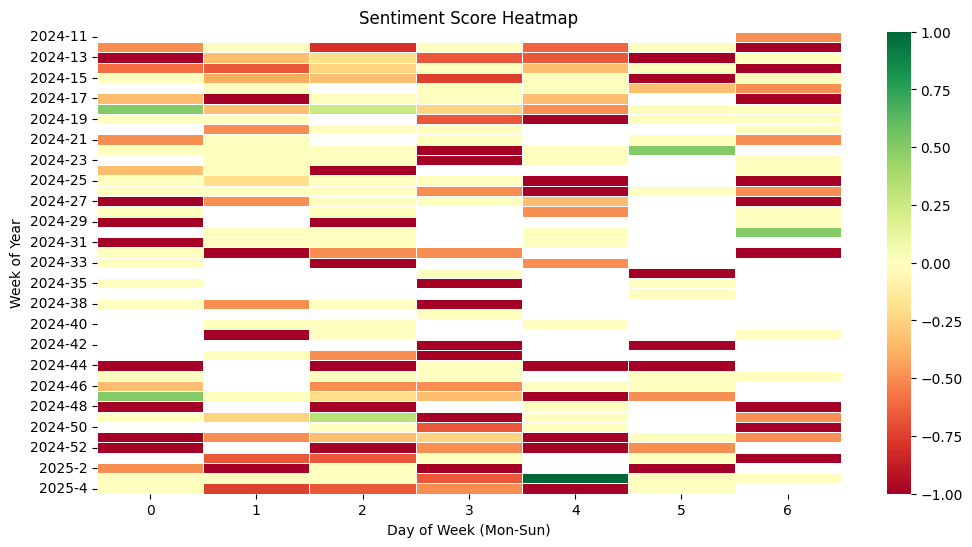

In [58]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data_2, cmap="RdYlGn", linewidths=0.5, linecolor="white", center=0, vmin=-1, vmax=1)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Sentiment Score Heatmap")
plt.show()

In [59]:
df_filtered.to_parquet('../data/processed/reddit_btc_wsbelite_relevant_posts_with_sentiment.parquet', index=False)

In [60]:
rate_limit_info = reddit.auth.limits
print(rate_limit_info)

{'remaining': 987.0, 'reset_timestamp': 1742187599.632353, 'used': 13}


In [61]:
from datetime import datetime

reset_time = pd.to_datetime(rate_limit_info['reset_timestamp'],unit = "s",utc = True).tz_convert("Asia/Singapore")  # Convert to UTC time
print("Rate limit resets at (SGT):", reset_time.strftime('%Y-%m-%d %H:%M:%S %Z'))

Rate limit resets at (SGT): 2025-03-17 12:59:59 +08
